# **TRABAJO DE FIN DE MASTER - MASTER EN INTELIGENCIA ARTIFICIAL**
**María Soledad Murias Palomer**

El objetivo de este trabajo es crear un modelo que permita predecir la venta futura por tienda de una serie de productos y, a partir de ella, optimizar el inventario de cada tienda dadas ciertas restricciones de espacio y reposición.

## Carga de librerías

In [1]:
# Importación de librerías
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder

In [2]:
from google.colab import drive
from google.colab import files
# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga de bases de datos

In [3]:
# Importación de datos
file1 = "/content/drive/My Drive/Colab Notebooks/0_TFM/2023.xlsx"
file2 = "/content/drive/My Drive/Colab Notebooks/0_TFM/2024.xlsx"
file3 = "/content/drive/My Drive/Colab Notebooks/0_TFM/2025.xlsx"
file4 = "/content/drive/My Drive/Colab Notebooks/0_TFM/2023 IRRENUNCIABLE.xlsx"
file5 = "/content/drive/My Drive/Colab Notebooks/0_TFM/2024 IRRENUNCIABLE.xlsx"

# Cargar el archivo en un DataFrame
data1 = pd.read_excel(file1)
data2 = pd.read_excel(file2)
data3 = pd.read_excel(file3)
data4 = pd.read_excel(file4)
data5 = pd.read_excel(file5)

In [4]:
df = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)
df = df.sort_values(by='Fecha', ascending=True)
df.describe()

,Fecha,Dia Sem,Sem del año,Uns,Neto final
count,2845641,2.845641e+06,2.845641e+06,2.845641e+06,2.845641e+06
mean,2024-02-01 14:54:04.985858048,3.998755e+00,2.838434e+01,6.810817e-01,2.379775e+04
min,2023-01-01 00:00:00,1.000000e+00,1.000000e+00,-5.000000e+01,-1.512184e+06
25%,2023-08-02 00:00:00,2.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00
50%,2024-01-01 00:00:00,4.000000e+00,3.000000e+01,1.000000e+00,1.091600e+04
75%,2024-09-18 00:00:00,6.000000e+00,4.300000e+01,1.000000e+00,4.368900e+04
max,2025-02-20 00:00:00,7.000000e+00,5.300000e+01,2.230000e+02,4.611194e+06
std,NaN,2.166952e+00,1.733450e+01,8.747704e-01,3.578920e+04


In [5]:
df['Evento'] = df['Evento'].fillna('NOEVENTO')
df['Uns'] = df['Uns'].clip(lower=0)
df['Nom_SubFamilia'] = df['Nom_SubFamilia'].apply(lambda x: 'SANDALIA' if x.startswith('SANDALIA') else x)

In [6]:
df.describe()

,Fecha,Dia Sem,Sem del año,Uns,Neto final
count,2845641,2.845641e+06,2.845641e+06,2.845641e+06,2.845641e+06
mean,2024-02-01 14:54:04.985858048,3.998755e+00,2.838434e+01,7.144137e-01,2.379775e+04
min,2023-01-01 00:00:00,1.000000e+00,1.000000e+00,0.000000e+00,-1.512184e+06
25%,2023-08-02 00:00:00,2.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00
50%,2024-01-01 00:00:00,4.000000e+00,3.000000e+01,1.000000e+00,1.091600e+04
75%,2024-09-18 00:00:00,6.000000e+00,4.300000e+01,1.000000e+00,4.368900e+04
max,2025-02-20 00:00:00,7.000000e+00,5.300000e+01,2.230000e+02,4.611194e+06
std,NaN,2.166952e+00,1.733450e+01,8.261449e-01,3.578920e+04


## Detección y eliminación de outliers

In [7]:
aux = df.copy()
aux['New_Cluster'] = aux['Nom_Marca'] + '_' + aux['Nom_SubFamilia']
num_valores_unicos = aux['New_Cluster'].nunique()
print(num_valores_unicos)

63


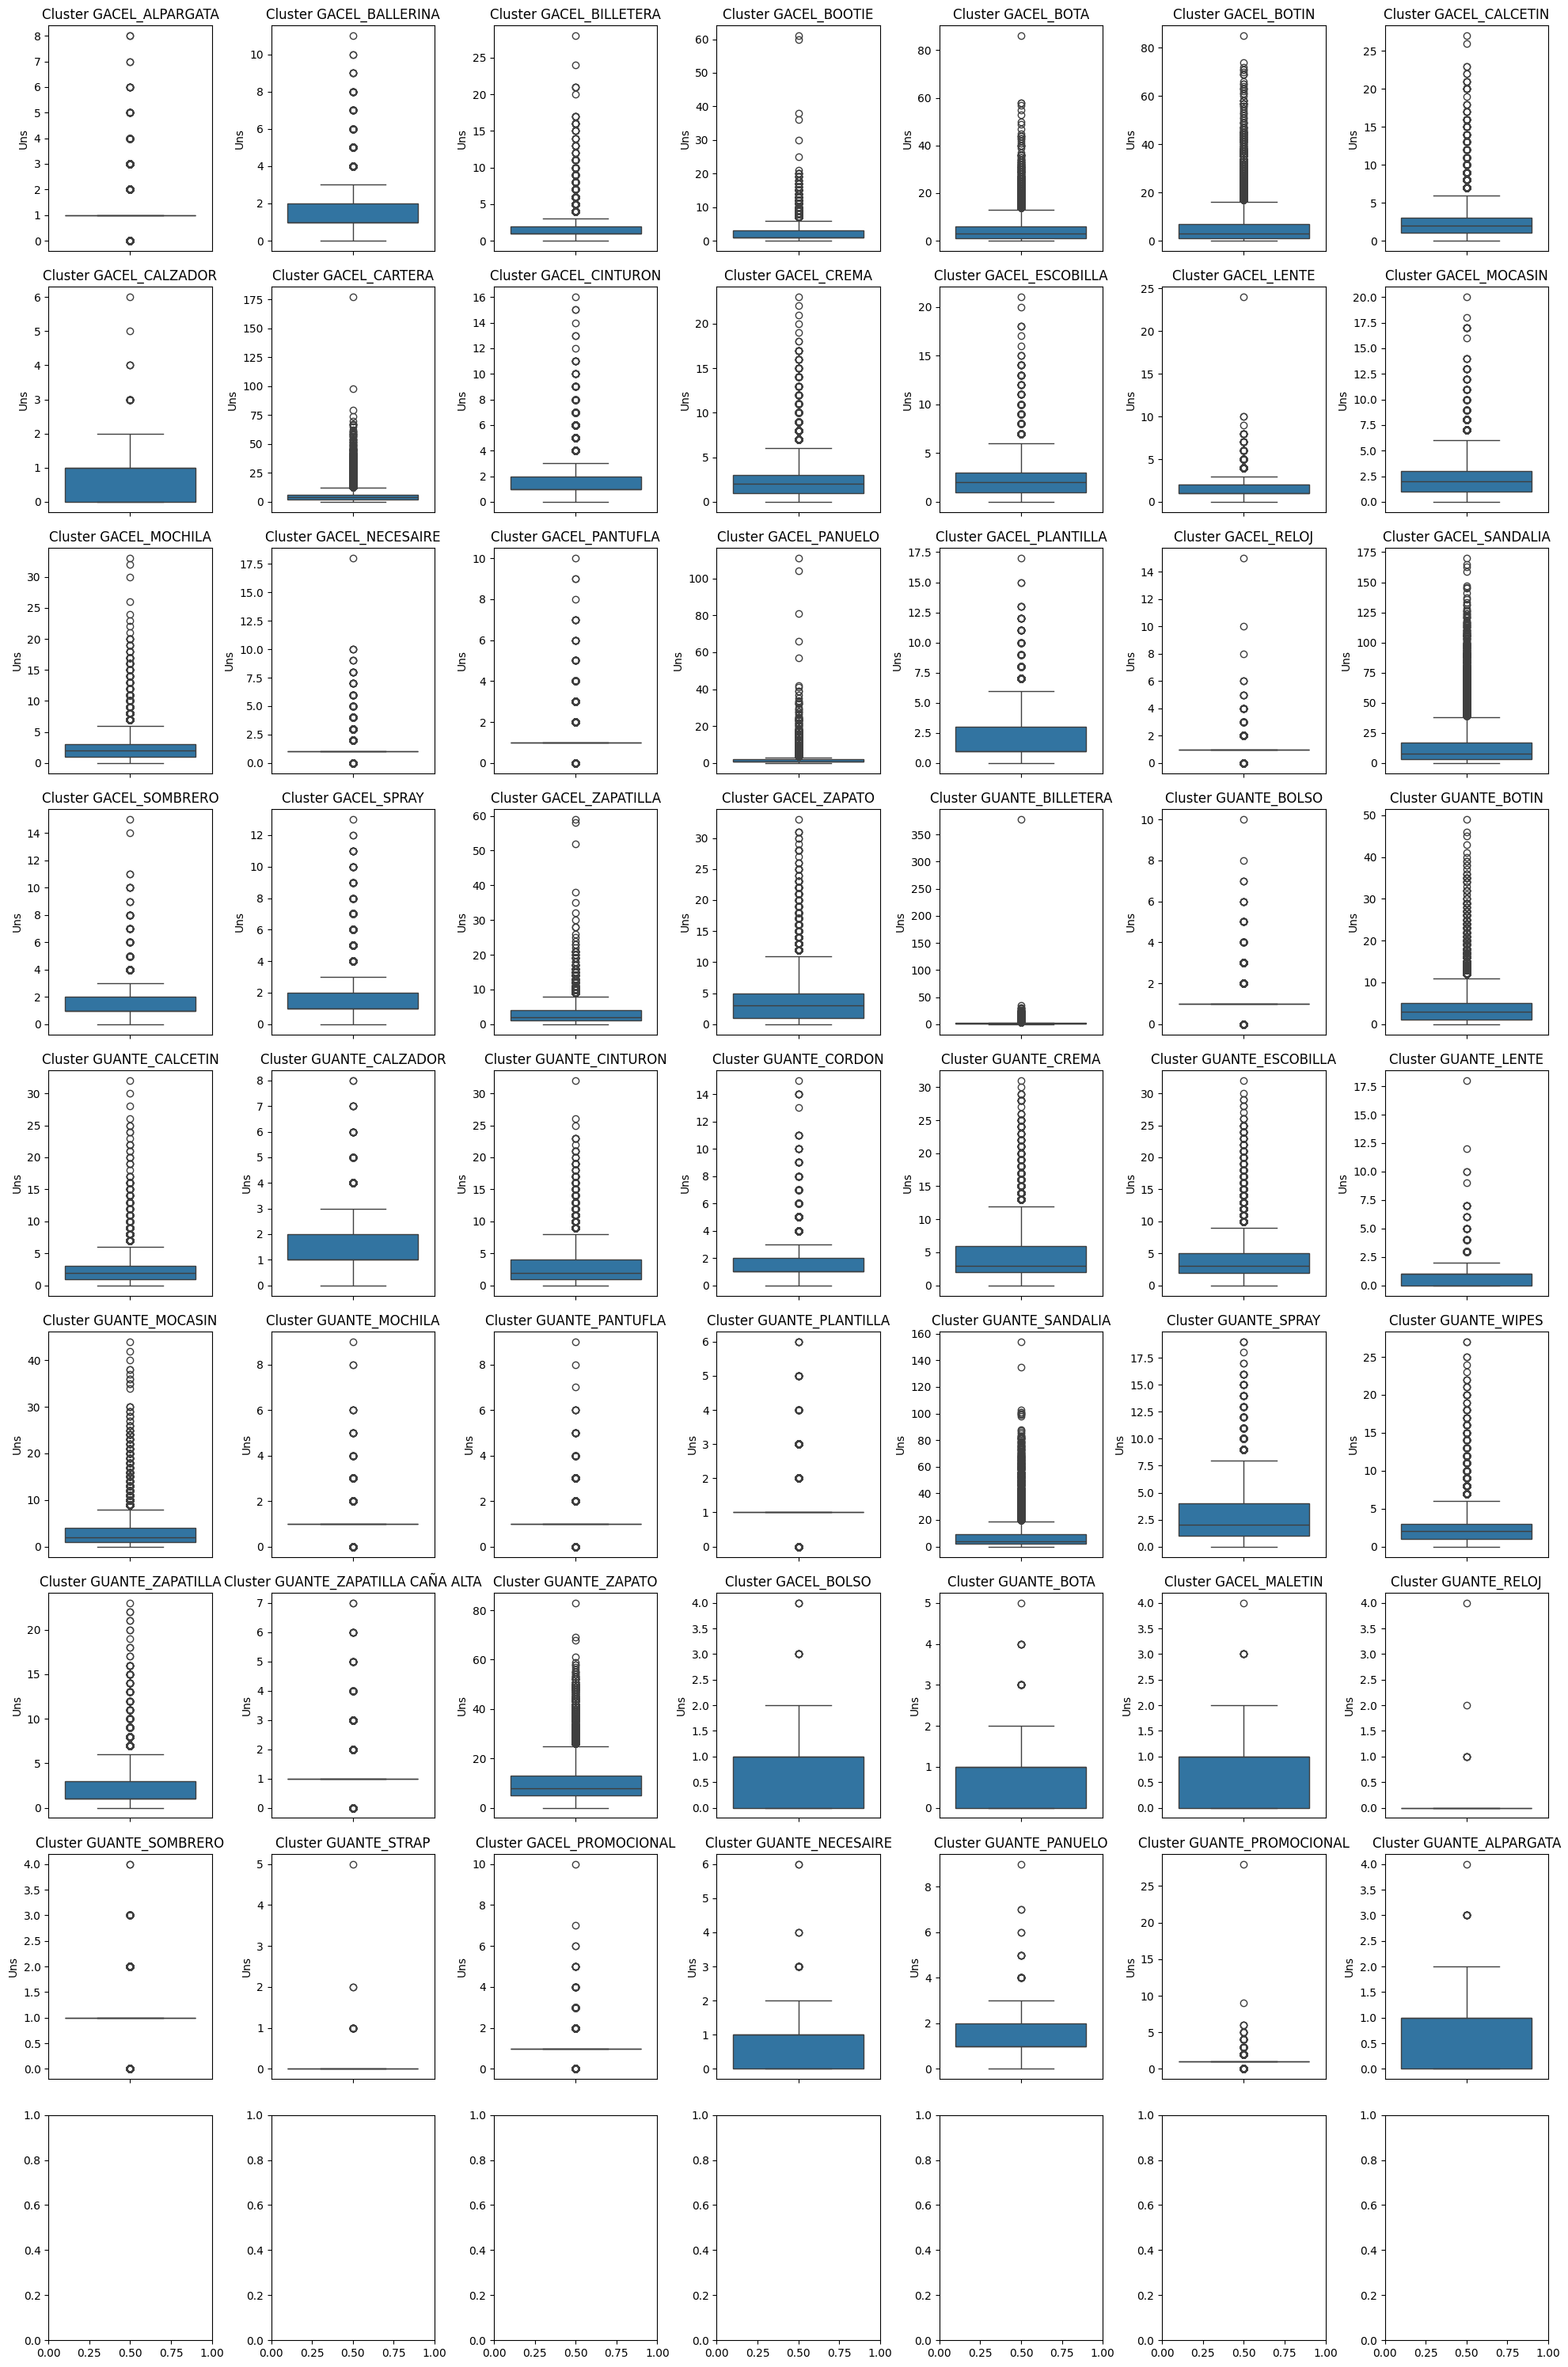

In [8]:
aux2 =aux.groupby(["Fecha", "Cliente", "New_Cluster"], as_index=False)["Uns"].sum()
aux2 = aux2[~aux2['New_Cluster'].isin(['GACEL_PUNTA', 'GACEL_STRAP', 'GUANTE_GUANTE', 'GUANTE_CAMPERA', 'GACEL_GUANTE', 'GUANTE_MASCARILLA', 'GACEL_OTRO ACCESORIO', 'GUANTE_BUFANDA'])]

# Crear subgráficos
fig, axes = plt.subplots(nrows=9, ncols=7, figsize=(20, 30))

# Obtener los valores únicos de 'New_Cluster'
clusters = aux2['New_Cluster'].unique()

# Dibuja un boxplot para cada valor único de 'New_Cluster'
for i, (cluster, ax) in enumerate(zip(clusters, axes.flat)):
    sns.boxplot(data=aux2[aux2['New_Cluster'] == cluster], y='Uns', ax=ax)
    ax.set_title(f'Cluster {cluster}')

plt.tight_layout()
plt.savefig("grafico_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Eliminación de outliers
indice = [261724, 261725, 486766, 486769, 960525, 960526, 1174913, 1174914]
df = df.drop(index=indice)

## Agrupación de datos

In [10]:
# Creamos una nueva base donde se elimina la columna Cod_Producto y se agrupa según las demás columnas, dejando el total de unidades y venta por día/cluster
data = df.copy()
data['New_Cluster'] = data['Nom_Marca'] + '_' + data['Nom_SubFamilia'] + '_' + data['Cluster']
data = data.groupby(["Fecha", "Dia Sem", "Sem del año", "Feriado", "Evento", "New_Cluster"], as_index=False)[["Uns", "Neto final"]].sum()

data.head()

,Fecha,Dia Sem,Sem del año,Feriado,Evento,New_Cluster,Uns,Neto final
0,2023-01-01,7,1,IRRENUNCIABLE,NOEVENTO,GACEL_ALPARGATA_ALPARGATA_CASUAL,0,0
1,2023-01-01,7,1,IRRENUNCIABLE,NOEVENTO,GACEL_BALLERINA_BALLERINA,0,0
2,2023-01-01,7,1,IRRENUNCIABLE,NOEVENTO,GACEL_BALLERINA_BALLERINA_VESTIR,0,0
3,2023-01-01,7,1,IRRENUNCIABLE,NOEVENTO,GACEL_BILLETERA_BILLETERA,0,0
4,2023-01-01,7,1,IRRENUNCIABLE,NOEVENTO,GACEL_BOLSO_BOLSO,0,0


In [11]:
# Agregamos el precio unitario (eliminando los nulos y errores)
data['PrecioUnit'] = data['Neto final'] / data['Uns']
data["PrecioUnit"] = data["PrecioUnit"].replace([np.inf, -np.inf], np.nan)  # Reemplazar infinitos por NaN
data["PrecioUnit"].fillna(0, inplace=True)

<ipython-input-11-7e1374dd02e2>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["PrecioUnit"].fillna(0, inplace=True)


In [12]:
# Ver las primeras filas
data.head()

# Revisamos la información del dataset
data.info()

# Revisamos si hay valores nulos
data.isnull().sum()

data.to_csv("data.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68920 entries, 0 to 68919
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Fecha        68920 non-null  datetime64[ns]
 1   Dia Sem      68920 non-null  int64         
 2   Sem del año  68920 non-null  int64         
 3   Feriado      68920 non-null  object        
 4   Evento       68920 non-null  object        
 5   New_Cluster  68920 non-null  object        
 6   Uns          68920 non-null  int64         
 7   Neto final   68920 non-null  int64         
 8   PrecioUnit   68920 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 4.7+ MB


## One Hot Encoding

In [13]:
# Estandarización de datos categóricos
cat_features = ["Feriado", "Evento", "New_Cluster"]
num_features = ["Fecha", "Dia Sem", "Sem del año", "Uns", 'PrecioUnit']

data_stnd = data.copy()

label_encoders = {}
encoded_dfs = []  # Lista para almacenar DataFrames codificados

for col in cat_features:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded_array = encoder.fit_transform(data_stnd[[col]])

    # Convertir a DataFrame con nombres de columnas adecuados
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out([col]), index=data_stnd.index)

    encoded_dfs.append(encoded_df)  # Guardamos el DataFrame codificado
    label_encoders[col] = encoder   # Guardamos el encoder para revertir si es necesario

# Concatenar todas las columnas codificadas con las numéricas originales
data_stnd = pd.concat([data_stnd[num_features]] + encoded_dfs, axis=1)

data_stnd.set_index('Fecha', inplace=True)

data_stnd.head()

,Dia Sem,Sem del año,Uns,PrecioUnit,Feriado_FERIADO,Feriado_IRRENUNCIABLE,Feriado_NORMAL,Evento_DIAMADRE,Evento_DIAPADRE,Evento_DIECIOCHO,...,New_Cluster_GUANTE_ZAPATO_ZAPATILLA_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO,New_Cluster_GUANTE_ZAPATO_ZAPATO_CASUAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_CASUAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_ESCOLAR,New_Cluster_GUANTE_ZAPATO_ZAPATO_FORMAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_FORMAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_INFORMAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_INFORMAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_OUTDOOR
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-01-01,7,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01,7,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
data_stnd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68920 entries, 2023-01-01 to 2025-02-20
Columns: 151 entries, Dia Sem to New_Cluster_GUANTE_ZAPATO_ZAPATO_OUTDOOR
dtypes: float64(148), int64(3)
memory usage: 79.9 MB


In [15]:
data_stnd.to_csv("dataframe.csv")